In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR
import yfinance as yf
from matplotlib import dates as dt
from numpy import linalg
import matplotlib.ticker as ticker
import matplotlib as mpl
import scipy.stats as stats

# Sentiment Data

In [120]:
df_sentiment = pd.read_csv("../data/sentiment_daily_data.csv")
df_sentiment.index = pd.DatetimeIndex(df_sentiment["release_date"]).to_period("D")
df_sentiment = df_sentiment.drop('release_date', axis = 1)
df_sentiment

,AAPL_daily,AAPL_diff,AMZN_daily,AMZN_diff,BAC_daily,BAC_diff,CVX_daily,CVX_diff,HD_daily,HD_diff,...,PFE_daily,PFE_diff,PG_daily,PG_diff,TSLA_daily,TSLA_diff,WMT_daily,WMT_diff,XOM_daily,XOM_diff
release_date,,,,,,,,,,,,,,,,,,,,,
2014-01-04,0.9747,-0.9876,0.9870,0.0,1.8862,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9595,0.0000
2014-01-05,2.6382,1.6635,0.9870,0.0,0.9956,-0.8906,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9977,0.0382
2014-01-06,2.6382,0.0000,0.9870,0.0,0.9956,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,-0.0010
2014-01-07,-0.2695,-2.9077,0.9870,0.0,2.9495,1.9539,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
2014-01-08,-0.2695,0.0000,0.9870,0.0,0.9862,-1.9633,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.7939,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,-0.6384,-0.9922,0.0000
2020-02-10,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.0000,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,-0.5306,0.4616
2020-02-11,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,0.0732,-1.8862,0.9975,0.0,...,1.5383,-0.4508,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,1.9926,2.5232


# Stock Data

In [121]:
df_prices = pd.read_csv("../data/stock_data_daily_pct_change.csv")
df_prices.index = pd.DatetimeIndex(df_prices["Date"]).to_period("D")
df_prices = df_prices.drop('Date', axis = 1)
df_prices = df_prices.drop("Date.1", axis = 1)

# Drop columns with little amount of data (determined in "Sentiment Timeseries.ipynb")
df_prices = df_prices.drop(["LLY", "NVDA", "MA", "UNH", "V"], axis = 1)
df_prices

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
Date,,,,,,,,,,,,,,,
2011-01-04,0.005219,0.003931,0.003524,0.004288,0.001878,0.004695,0.014473,-0.020699,0.003849,-0.003698,0.008437,-0.018125,0.002779,0.008602,0.017534
2011-01-05,0.008180,-0.003204,0.018258,0.013026,0.005999,-0.002670,0.012229,-0.005950,-0.006573,-0.001747,-0.000631,-0.003172,-0.002310,0.005777,0.006671
2011-01-06,-0.000808,0.029286,-0.004138,-0.008324,0.039135,0.006426,-0.004922,-0.007245,-0.008270,-0.008202,-0.001580,-0.004051,-0.001698,0.013676,0.003865
2011-01-07,0.007161,-0.007634,-0.013158,-0.001991,0.012912,0.005453,-0.018885,-0.001745,0.002224,0.005514,-0.009650,-0.001162,-0.002937,0.007825,0.008801
2011-01-10,0.018833,-0.013287,0.010526,-0.004367,0.007436,-0.006086,-0.005500,0.002225,-0.006472,-0.008554,-0.007029,0.000291,-0.002171,-0.004016,-0.004362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.016319,0.000000,0.006007,0.003638,0.033605,0.005004,-0.000292,-0.001092,-0.010475,0.005431,0.002602,-0.008952,-0.003670,0.001747,0.002294
2019-12-24,0.000951,-0.000191,0.001422,-0.002114,0.014384,-0.003842,0.002770,-0.003642,0.004033,0.000083,-0.003483,0.006660,0.002562,-0.003270,-0.000763
2019-12-26,0.019840,0.008197,0.008518,0.044467,0.013380,0.001571,0.010612,0.005666,0.000084,0.002160,-0.000685,0.000680,0.000000,-0.001093,0.002291


# VAR model of sentiment and prices


In [122]:
def var_model(df_sentiment: pd.DataFrame, df_prices: pd.DataFrame)-> tuple[VAR, pd.DataFrame]:
    """
    Make a VAR model for a specific stock

    Returns a tuple of the VAR model and a merged dataframe consisting of the prices and
    the sentiment.
    """
    merged_df = pd.merge(df_prices, df_sentiment, left_index= True, right_index = True)
    new_names = {df_sentiment.name: f"{df_prices.name}_sentiment", df_prices.name: f"{df_prices.name}_prices"}
    merged_df = merged_df.rename(new_names, axis=1)
    return VAR(merged_df), merged_df

In [123]:
merged_df

,PFE_prices,PFE_sentiment
2014-01-06,0.000983,0.0
2014-01-07,0.006220,0.0
2014-01-08,0.006831,0.0
2014-01-09,-0.000646,0.0
2014-01-10,-0.007759,0.0
...,...,...
2019-12-23,0.002294,0.0
2019-12-24,-0.000763,0.0
2019-12-26,0.002291,0.0
2019-12-27,-0.001524,0.0


In [124]:
# Make a VAR model of all stocks

var_models = []
merged_dfs = []
for ticker in df_prices.columns:
    var, merged_df = var_model(df_sentiment[f"{ticker}_diff"], df_prices[ticker])
    var_models.append(var)
    merged_dfs.append(merged_df)

In [125]:
results = []
for model in var_models:
    result = model.fit(maxlags=35, ic='aic')
    results.append(result)
    print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Dec, 2022
Time:                     05:04:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.27623
Nobs:                     1492.00    HQIC:                  -3.39675
Log likelihood:          -1592.73    FPE:                  0.0311691
AIC:                     -3.46833    Det(Omega_mle):       0.0300709
--------------------------------------------------------------------
Results for equation AAPL_prices
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001052         0.000412            2.556           0.011
L1.AAPL_prices             0.018722         0.026095            0.717           0.473
L1.AAPL_sentiment         -0.00001

# Testing asssumptions

### Assumption 1
The mean of the residuals should be approximately zero:

In [126]:
for result in results:
    sentiment = result.names[0]
    price = result.names[1]
    print(f"{sentiment} resid. mean = ",result.resid[sentiment].mean())
    print(f"{price} resid. mean = ", result.resid[price].mean())

AAPL_prices resid. mean =  -3.7205865436499885e-20
AAPL_sentiment resid. mean =  -1.2191617986232282e-15
MSFT_prices resid. mean =  -7.083357108085284e-19
MSFT_sentiment resid. mean =  -6.012651759957866e-16
BAC_prices resid. mean =  -1.1109636670698698e-18
BAC_sentiment resid. mean =  -2.3700558230823888e-17
AMZN_prices resid. mean =  3.154042683594195e-19
AMZN_sentiment resid. mean =  -7.409402859530457e-16
TSLA_prices resid. mean =  -7.396555793638618e-19
TSLA_sentiment resid. mean =  -1.8935182831714862e-17
XOM_prices resid. mean =  9.899488636240979e-19
XOM_sentiment resid. mean =  1.5631940186722203e-16
JPM_prices resid. mean =  2.0340528432506198e-19
JPM_sentiment resid. mean =  9.467591415857431e-18
KO_prices resid. mean =  -8.157951416751317e-19
KO_sentiment resid. mean =  -3.9158166800406325e-17
WMT_prices resid. mean =  1.3322676295501879e-18
WMT_sentiment resid. mean =  9.592326932761352e-17
CVX_prices resid. mean =  -8.91148916087082e-19
CVX_sentiment resid. mean =  -7.604

### Assumption 2

Covariance matrix of the errors should be positive semi definite:

In [127]:
for result in results:
    cov_matrix = result.resid_corr
    print(linalg.eigvals(cov_matrix))

[1.04662188 0.95337812]
[1.00788712 0.99211288]
[0.92905974 1.07094026]
[0.94624465 1.05375535]
[1.03531543 0.96468457]
[0.95911783 1.04088217]
[1.00378321 0.99621679]
[0.98846532 1.01153468]
[1.09339304 0.90660696]
[0.98085952 1.01914048]
[1.03034024 0.96965976]
[1.07884307 0.92115693]
[1.03233171 0.96766829]
[1.00850229 0.99149771]
[1.06631872 0.93368128]


### Assumption 3

Residuals should be uncorrelated:

In [128]:
for result in results:
    print(f"{result.names[0]} and {result.names[1]}:")
    print(result.test_whiteness(result.k_ar+1).summary(), "\n \n")

AAPL_prices and AAPL_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 14 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.813          9.488   0.590  4
---------------------------------------- 
 

MSFT_prices and MSFT_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 17 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.042          9.488   0.060  4
---------------------------------------- 
 

BAC_prices and BAC_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 7 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.642       

### Assumption 4

Data should be normally distributed:

In [129]:
for result in results:
    print(result.test_normality().summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     1.876e+04          9.488   0.000  4
----------------------------------------
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     1.066e+05          9.488   0.000  4
----------------------------------------
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         1889.          9.488   0.000  4
----------------------------------------
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Concl

Assumption 3 and 4 are not met for most stocks. Let's still try to forecast.

# Forecasting

In [130]:
def forecast(results, merged_df) -> tuple:
    """Forecast result of the VAR fit 14 timesteps ahead using prior sentiment and price
    data."""

    # get ticker name by removing "_prices"
    ticker = results.names[0][:-7]

    # last date in train set: 2019-12-30
    # downloading testset
    test_prices = pd.DataFrame(yf.Ticker(ticker).history(start = '2019-12-30', end = '2020-1-20')['Close'])
    forecast_df = pd.DataFrame(results.forecast(np.array(merged_df), 14))
    forecast_df.columns = ['price', 'sentiment']

    # recall stock price is percent change, and sentiment is differences
    # undoing the differencing of APPL_sentiment by taking the cumsum
    initial_value = test_prices.iloc[0,:]
    forecast_df["sentiment"].cumsum(axis = 0)
    forecasted_prices = forecast_df.assign(price=forecast_df.price.pct_change(-1)+initial_value[0])
    forecasted_prices['price'].index = test_prices.index

    return forecasted_prices, test_prices

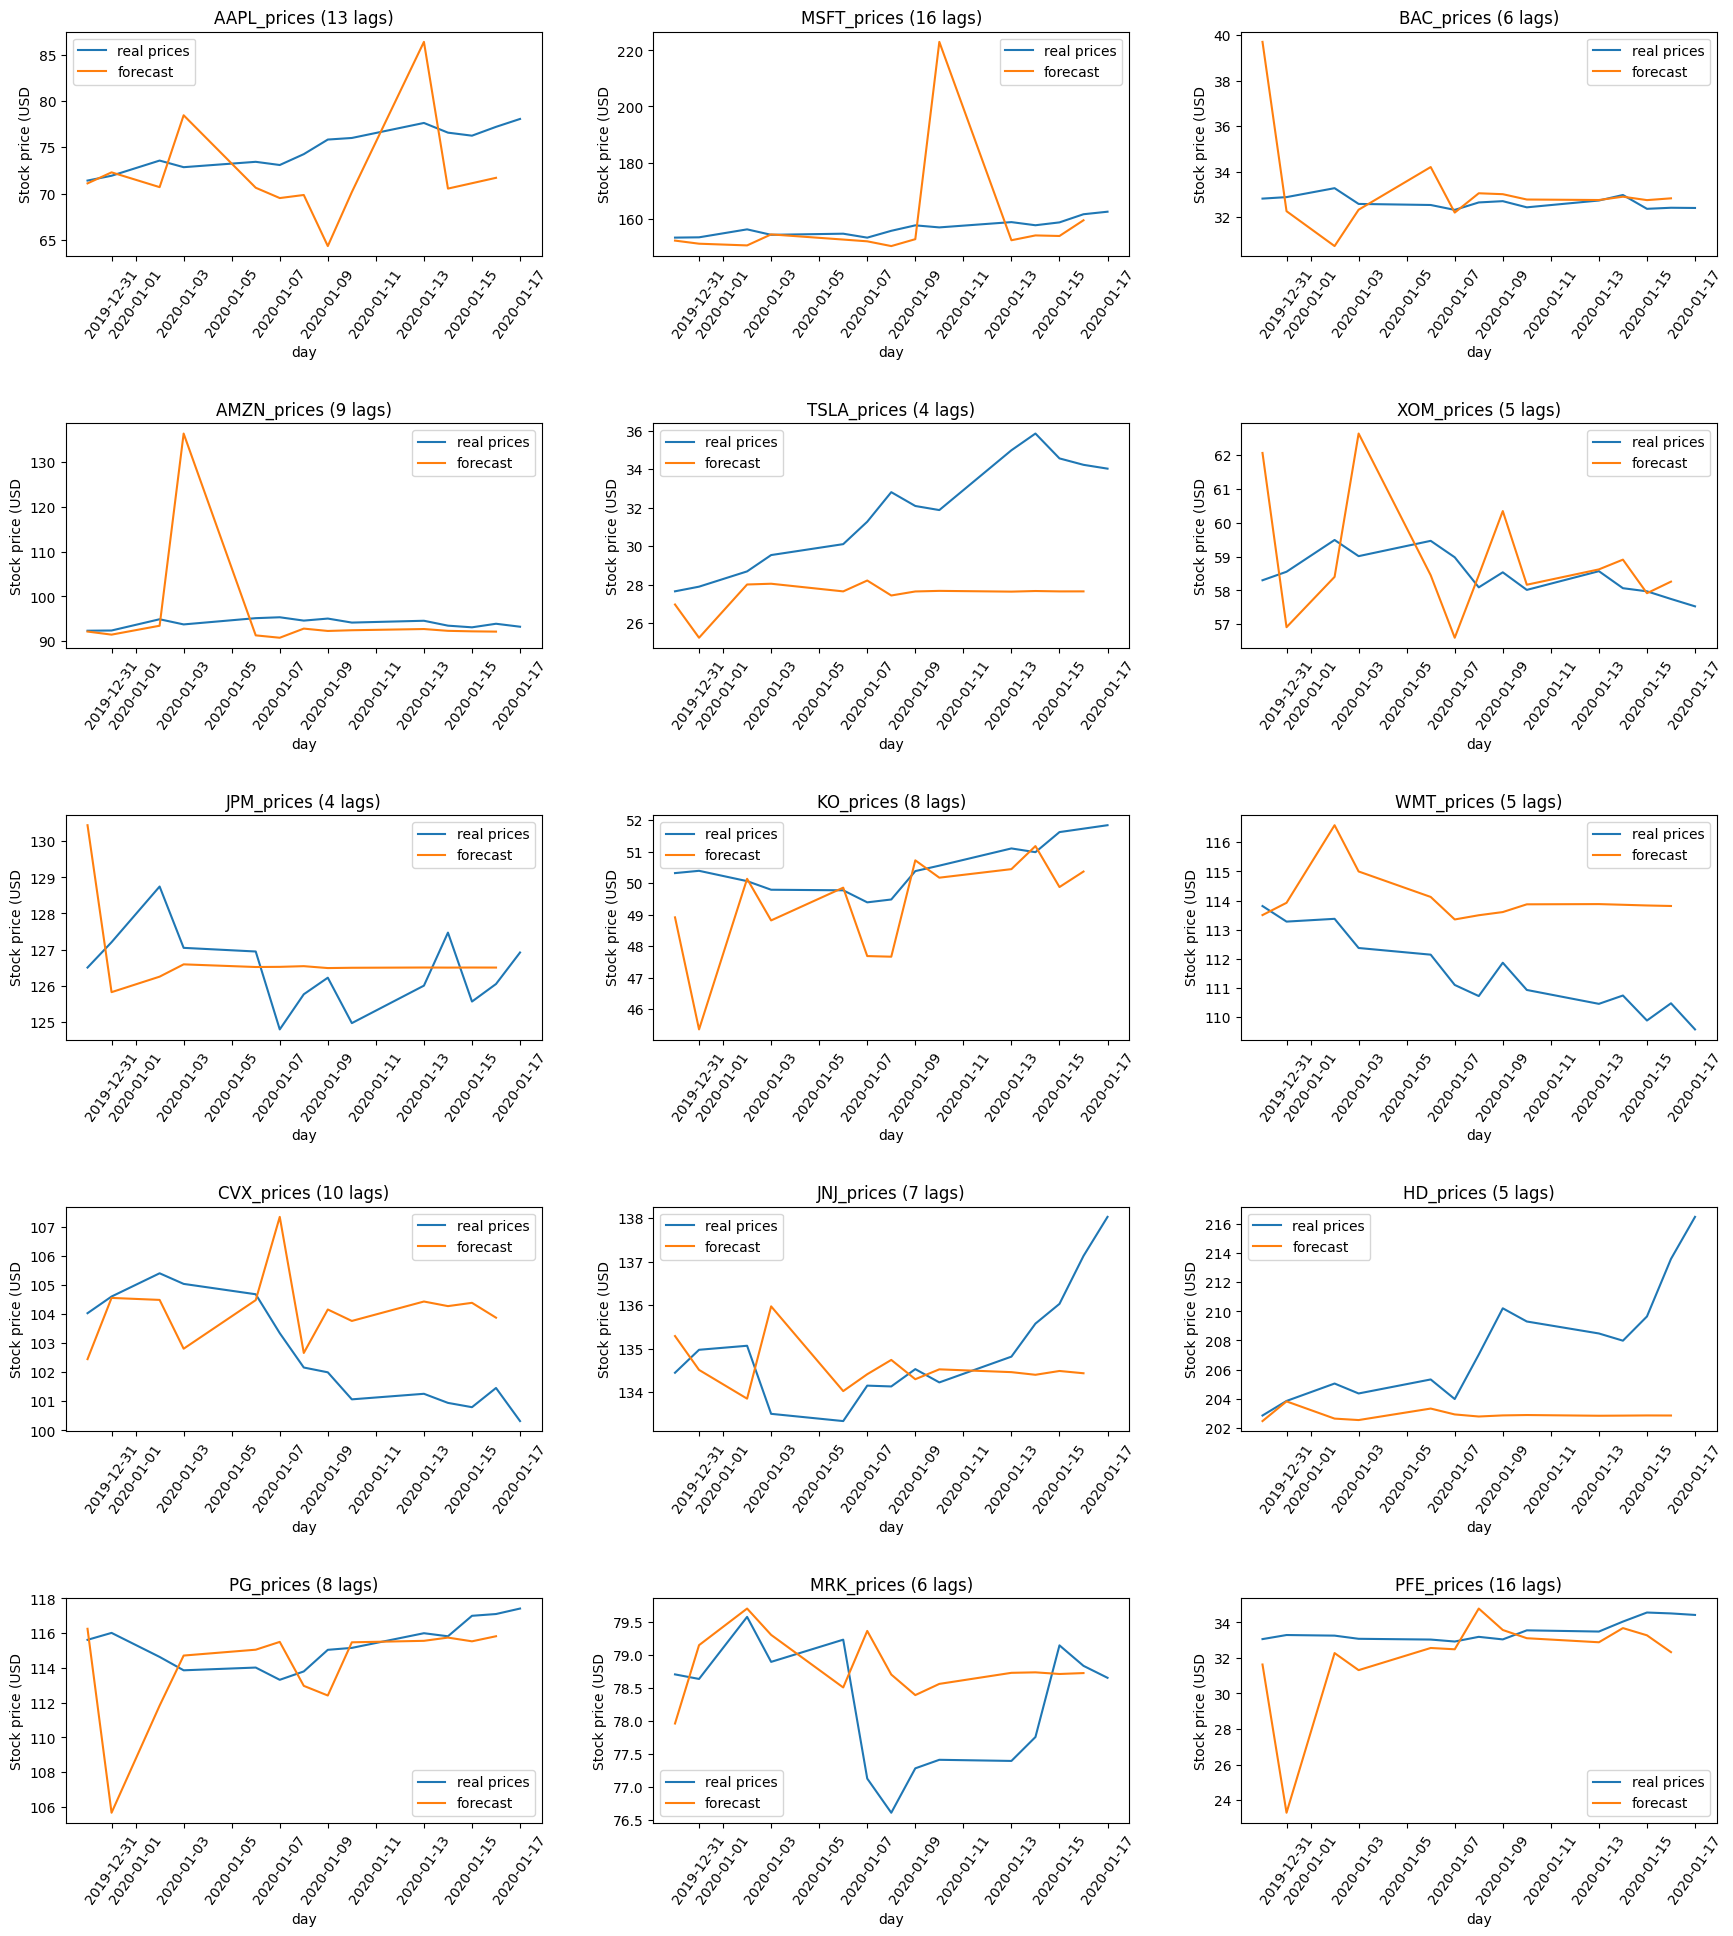

In [131]:
fig = plt.figure(figsize = (18, 20))
i = 0
for result, merged_df in zip(results, merged_dfs):
    i+=1
    forecasted, real_prices = forecast(result, merged_df)
    plt.subplot(5, 3, i)
    plt.title(f"{result.names[0]} ({result.k_ar} lags)" )
    plt.xlabel('day')
    plt.ylabel('Stock price (USD')
    days = real_prices.index
    plt.plot(days, real_prices["Close"], label='real prices')
    plt.plot(days, forecasted["price"], label='forecast')
    plt.xticks(rotation=55)
    plt.legend()
fig.tight_layout(pad = 3)
plt.show()

# Using sliding windows for forecast

We can observe in the graphs above that the forecast is of moderate quality. Let's try another tactic: dividing the data in windows and fitting each to the VAR model,
to generate multiple predictions per stock. First we test this sliding window method one stock.

In [132]:
def sliding_windows(df, window_size) -> list:
    """Create sliding windows of timeseries for each variable in the dataframe"""

    list_of_windows_per_variable = []
    for variable in df.columns:
        variable_timeseries = df[str(variable)]
        windows = []

        # Iterate over the time series
        for i in np.arange(len(variable_timeseries.index) - window_size + 1, step = window_size):

            # Take the last `window_size` elements of the time series
            # windows are non overlapping, i.e. the first window is from index 0-20, the next from 20-40 etc.
            current_window = variable_timeseries[i : i+window_size]
            window_index = variable_timeseries.index[i : i+window_size]
            # Add the current window to the list of windows
            windows.append(pd.DataFrame(current_window, index = window_index))
        list_of_windows_per_variable.append(windows)

    return list_of_windows_per_variable

In [133]:
# Sliding windows for AAPL
windows = sliding_windows(merged_dfs[0], window_size = 78)
windows_prices = windows[0]
windows_sentiment = windows[1]


In [134]:
len(windows_sentiment)

19

In [135]:
def VAR_model_windows(windows):
    """Return a tuple containing a list of the VAR models of all windows and a list of
    merged prices/sentiment dataframes."""

    merged_windows = []
    VAR_models = []
    for window_prices, window_sentiments in zip(windows[0], windows[1]):
        merged_window = pd.merge(window_prices, window_sentiments, left_index= True, right_index = True)
        merged_windows.append(merged_window)
        VAR_models.append(VAR(merged_window))

    return VAR_models, merged_windows

In [136]:
var_models_windows, merged_windows = VAR_model_windows(windows)

window_results = []
for model in var_models_windows:
    result = model.fit(13)
    window_results.append(result)

In [137]:
def forecast_windows(window_results: list, merged_windows: list) -> tuple:
    """Returns a tuple of a list containing forecasted prices for all windows and a
    list of the real prices"""

    forecasted_prices = []
    for result, merged_df in zip(window_results, merged_windows):
        forecasted, real_prices = forecast(result, merged_df)
        forecasted_prices.append(forecasted["price"])
        days = real_prices.index

    return forecasted_prices, real_prices


def plot_forecasts(forecasted_prices: list, real_prices: pd.DataFrame):
    """Plot the forecasts of all windows and the real prices in one figure."""

    days = real_prices.index

    for forecast in forecasted_prices:
        line1, = plt.plot(days, forecast, label='forecast', color="blue", alpha=0.4)

    line2, = plt.plot(days, real_prices["Close"], label='real prices', color = "red")
    plt.title(f"{result.names[0]} ({result.k_ar} lags)" )
    plt.xticks(rotation=55)
    plt.xlabel('day')
    plt.ylabel('Stock price (USD')
    plt.legend([line1, line2], ["Forecast", "Real price"])
    plt.show()

In [138]:
forecasted_prices, real_prices = forecast_windows(window_results, merged_windows)
plot_forecasts(forecasted_prices, real_prices)

Exception: Tkr AAPL tz already in cache

In [ ]:
def mean_forecasts(forecasted_prices: list) -> tuple:
    """Compute the mean and 95% confidence interval of the window forecasts per timepoint"""

    df_mean = pd.concat(forecasted_prices, axis=1).agg(['mean'], axis=1)
    df = pd.DataFrame(forecasted_prices)
    df_percentiles = pd.DataFrame()
    for date in df:
        df_percentiles[date] = [np.percentile(df[date], 2.5), np.percentile(df[date], 97.5)]
    df_percentiles = df_percentiles.T
    df_percentiles.columns = ["Upper 95% CL", "Lower 95% CL"]

    return df_mean, df_percentiles


def plot_mean_forecasts(
    df_mean: pd.DataFrame,
    df_percentiles: pd.DataFrame,
    real_prices: pd.DataFrame
    ):

    df_percentiles.plot(style="--", color="red")
    df_mean["mean"].plot(label = "Mean forecast")
    real_prices["Close"].plot(label = "Real price")

    plt.legend()
    plt.ylabel("Stock price (USD)")
    plt.xlabel("Date")
    plt.show()

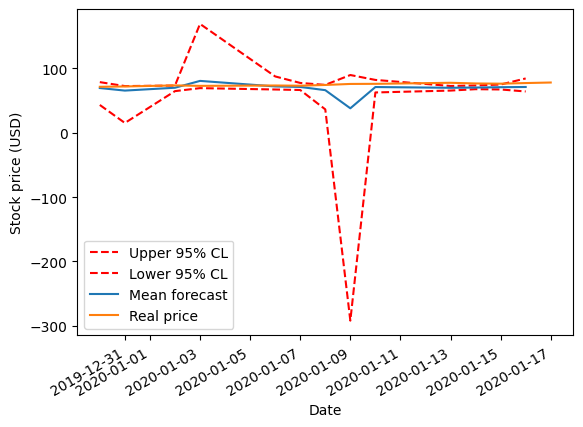

In [ ]:
df_mean, df_percentiles = mean_forecasts(forecasted_prices)
plot_mean_forecasts(df_mean, df_percentiles, real_prices)

# Assumption tests of sliding windows

### All 4 assumption tests:

In [ ]:
def normallity_of_residuals(result) -> bool:
    """
    This function tests the normality of residuals, given these residuals and returns
    the p value. Test using significance of alpha = 0.05
    reference: https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_normality.html
    """

    p_value = pd.DataFrame(result.test_normality().summary().data).iloc[1,2]
    if p_value < 0.05:
            significant_p = True
    else:
            significant_p = False
    return significant_p


def autocorrelation_of_residuals(result) -> bool:
    """
    This function tests the autocOrrelation of residuals, given these residuals and
    returns the p values.
    reference: https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_whiteness.html
    """

    p_value = pd.DataFrame(result.test_whiteness(result.k_ar+1).summary().data).iloc[1,2]
    if p_value < 0.05:
            significant_p = True
    else:
            significant_p = False
    return significant_p


def check_mean_of_residuals(result) -> tuple:
    """
    checking if residuals of a VAR results containing the residuals of 2 respective
    timeseries have mean 0 and returns a tuple containing boolean values.
    reference: https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.resid.html
    """
    sentiment = result.names[0]
    price = result.names[1]
    if result.resid[sentiment].mean() < 0.001:
        sentiment_timeseries_residual_mean_of_0 = True
    if result.resid[price].mean() < 0.001:
        price_timeseries_residual_mean_of_0 = True
    if sentiment_timeseries_residual_mean_of_0 and price_timeseries_residual_mean_of_0:
        return True
    else:
        return False

def matrix_is_postivive_and_semidefinite(matrix) -> bool:
    """
    checking if covariance matrix is positive and semi-definite. This can be checked by
    checking of the matrix is symetric and eigenvalues are positive.
    ref: https://en.wikipedia.org/wiki/Definite_matrix
    """

    cov_matrix = result.resid_corr
    cov_matrix = result.resid_corr
    is_symmetric = cov_matrix.shape[0] == cov_matrix.shape[1]
    eigen_values = linalg.eigvals(cov_matrix)
    eigen_values_positive = eigen_values[0]> 0 and eigen_values[1] > 0
    if is_symmetric and eigen_values_positive:
        covariance_matrix_positive_and_semi_definite = True
    else:
        covariance_matrix_positive_and_semi_definite = False
    return covariance_matrix_positive_and_semi_definite

def variance_of_residuals(result) -> bool:
    """
    checking if variance of residuals is constant over time. This can be checked by the levene test, splitting the residuals in 5 groups and checking if the p value is above 0.05.
    reference # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
    """
    df = pd.DataFrame(result.resid)
    variance_constant_for_variable= []
    for variable in df.columns:
        variable_to_test = df[variable]
        g1,g2,g3,g4,g5 = np.array_split(variable_to_test, 5)
        variance_constant_over_time = True if stats.levene(g1,g2,g3,g4,g5)[1]>= 0.05 else False  
        variance_constant_for_variable.append(variance_constant_over_time)
    if variance_constant_for_variable[0] and variance_constant_for_variable[1]:
        return True
    else:
        return False
    


Let's use these function to make one assumption matrix:

In [ ]:
def Assumption_matrix(window_results: list) -> pd.DataFrame:
    """Creates a dataframe of assumption test results per window, where true is the value
    if the assumption passes and False when it does not"""

    assumption_test_dict = {}
    for i, window_result in enumerate(window_results):
        stock_name = f"{window_result.names[0]}_window_{i}"
        dict_of_assumption_test_results = {str(stock_name):
        {'Mean of residuals = 0':check_mean_of_residuals(window_result),
            'Autocorrelation of residuals = 0': autocorrelation_of_residuals(window_result),
            'Covariance Matrix positive and semidefinite':matrix_is_postivive_and_semidefinite(window_result),
            'normality of residuals':normallity_of_residuals(window_result),
            'variance of residuals constant over time': variance_of_residuals(window_result)}}
        assumption_test_dict.update(dict_of_assumption_test_results)

    return pd.DataFrame(assumption_test_dict)

In [ ]:
def plot_assumptions(matrix):
    """Plot the assumption matrix for all windows of a specific stock"""

    fig, ax = plt.subplots(1,1)
    cmap = (mpl.colors.ListedColormap(['red', 'green']))
    ax.imshow(matrix, cmap=cmap)
    ax.set_yticks(range(5))
    # ax.set_xticks(range(28))
    ax.set_yticklabels([
        "Error mean = 0",
        "Residual Autocorrelation = 0",
        "Covariance matrix positive and semi definite",
        "Normality of residual",
        'variance of residuals constant over time'
        ])
    plt.xlabel("window")
    plt.ylabel("test")
    plt.title(f"{window_results[0].names[0]}")
    plt.show()

In [ ]:
matrix = Assumption_matrix(window_results)
matrix.shape
# plot_assumptions(matrix)

(5, 19)

In [ ]:
window_results

# Forecast and assumption test for all stocks

In [ ]:
lags_stocks = [result.k_ar for result in results]
lags_stocks

[13, 16, 6, 9, 4, 5, 4, 8, 5, 10, 7, 5, 8, 6, 16]

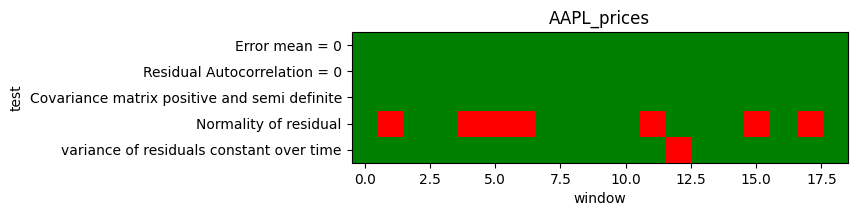

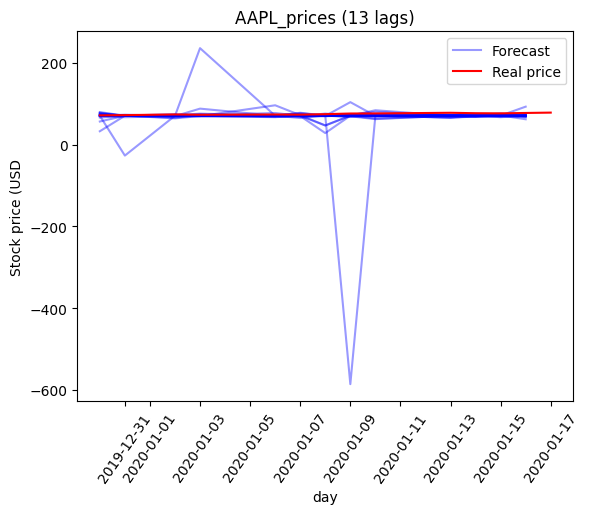

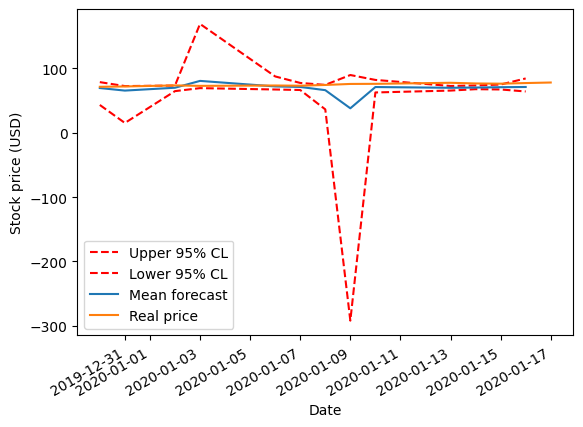

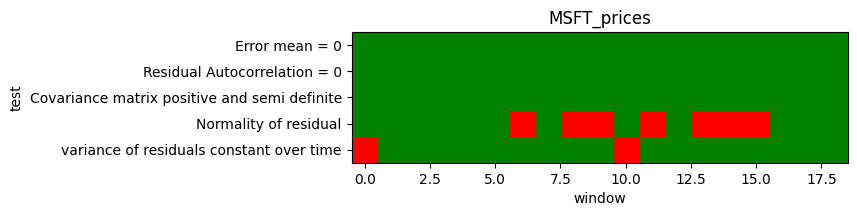

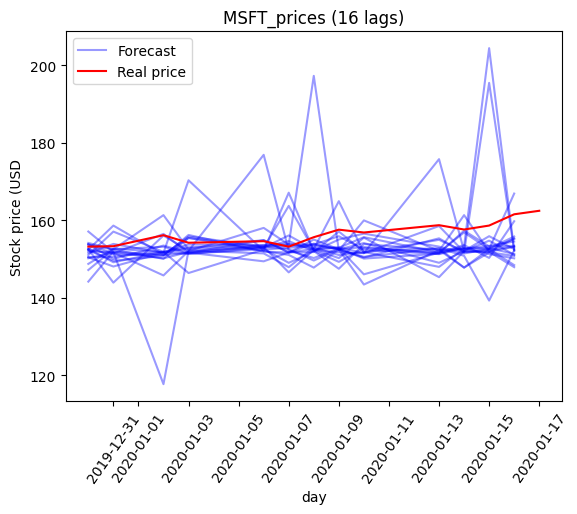

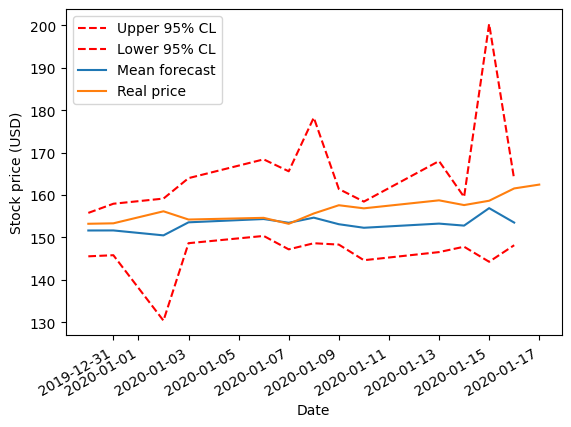

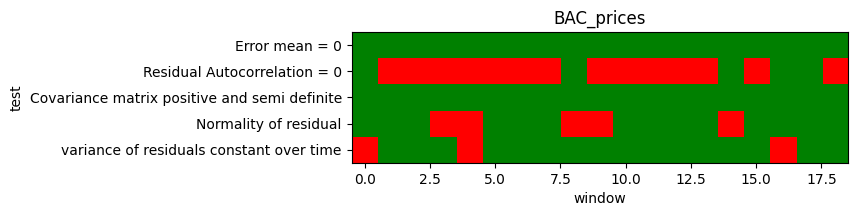

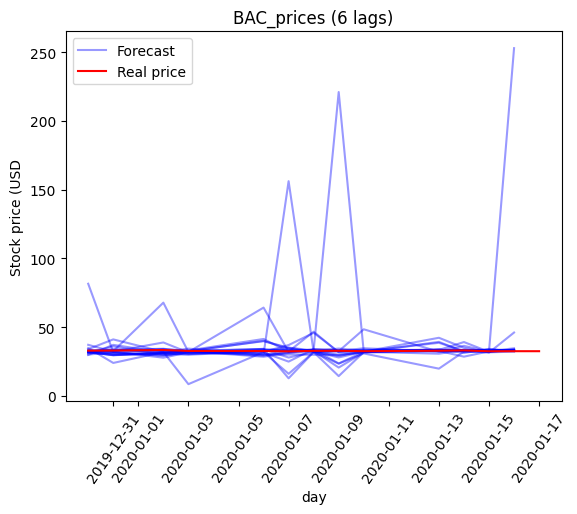

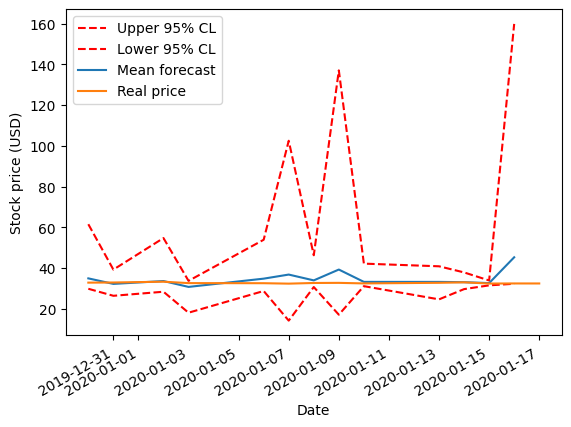

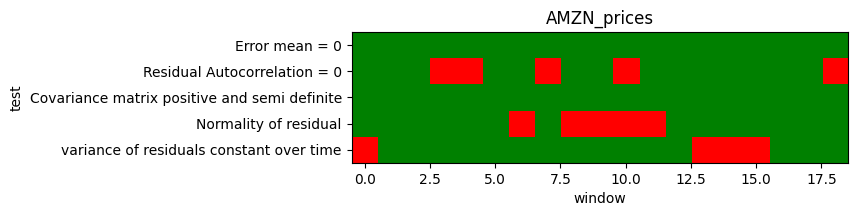

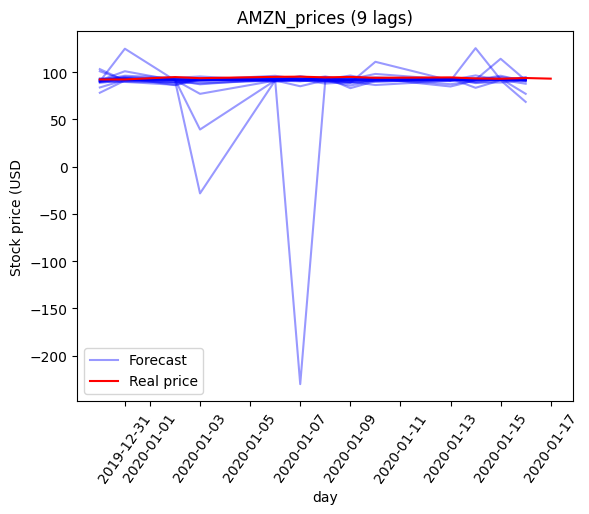

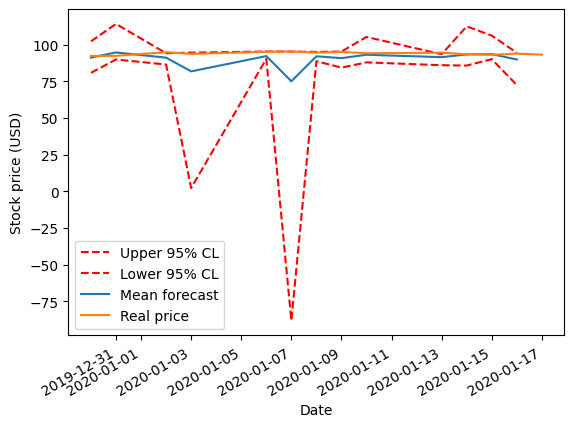

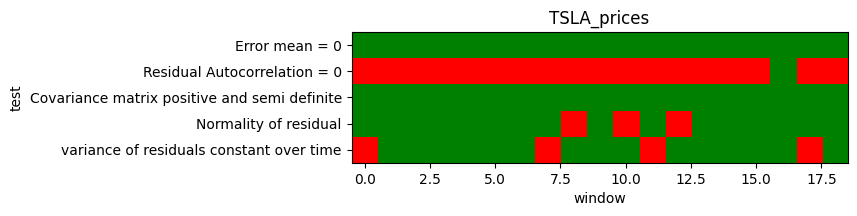

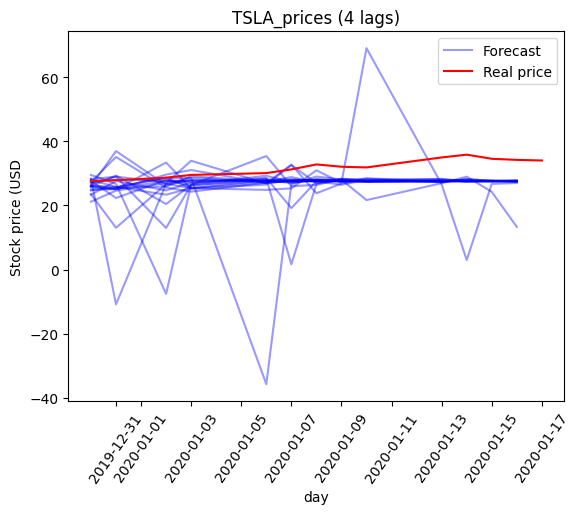

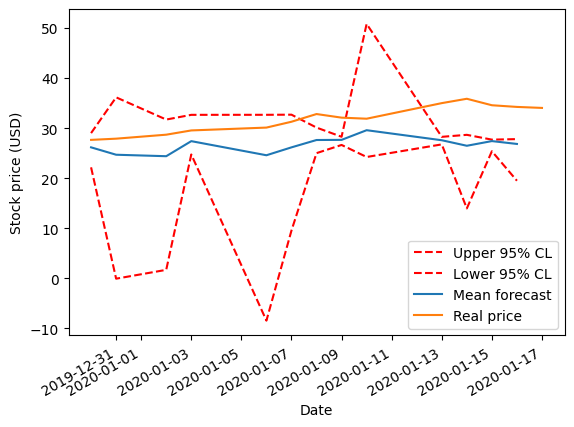

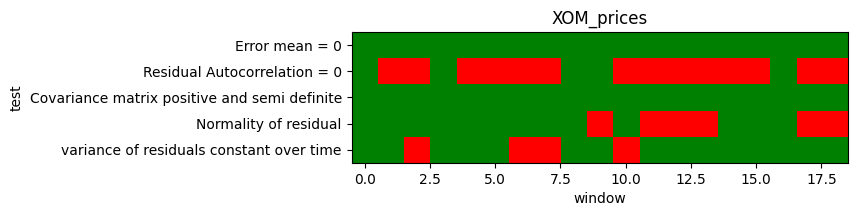

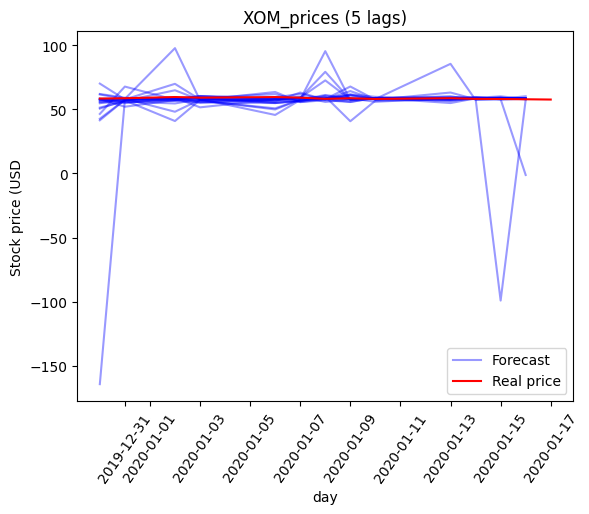

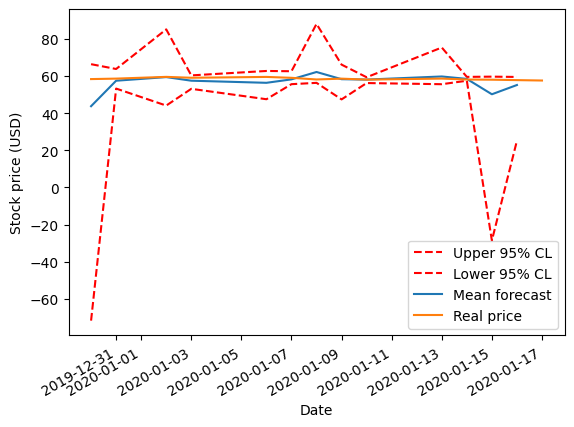

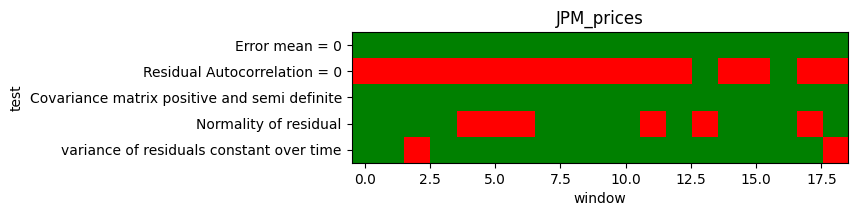

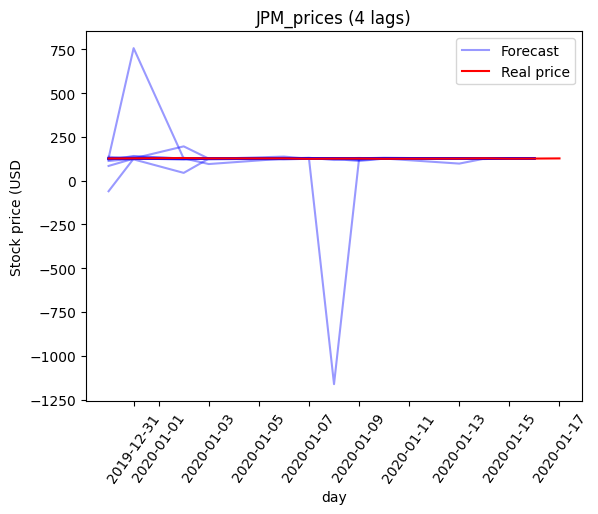

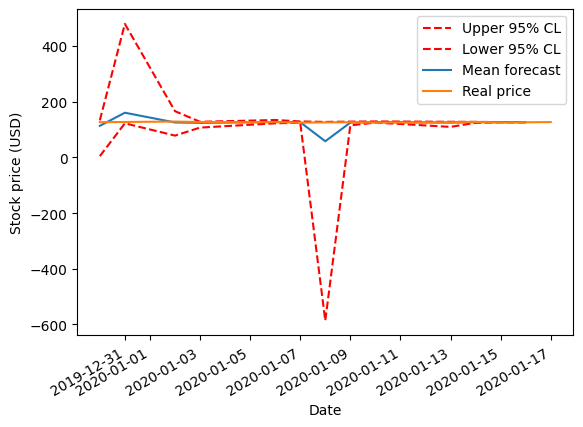

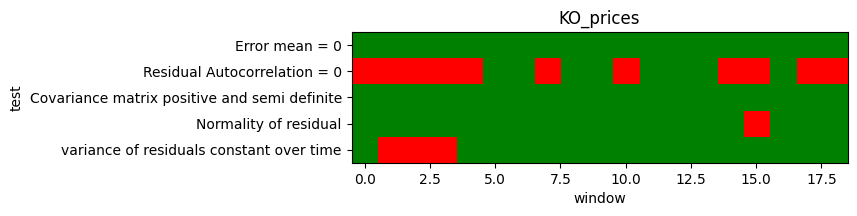

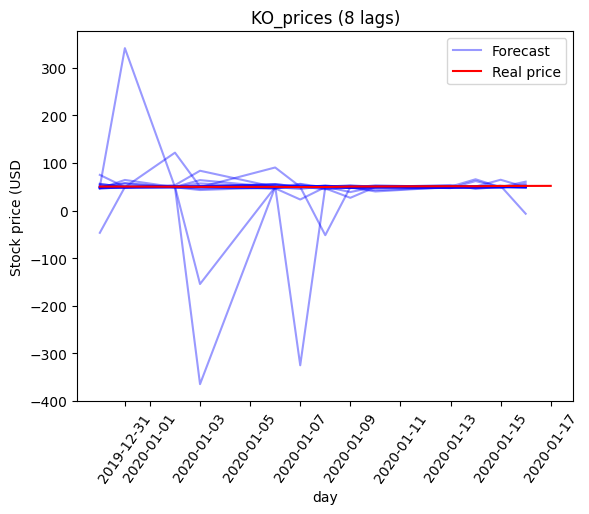

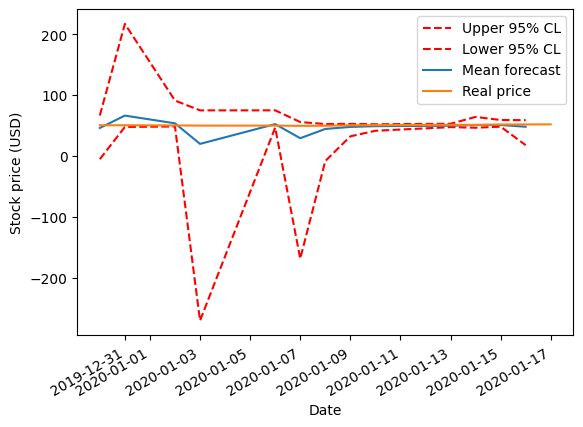

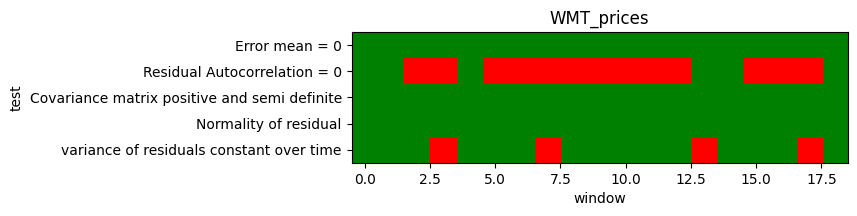

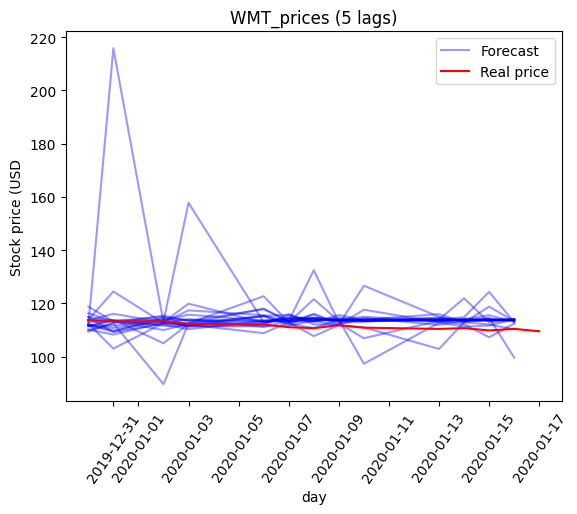

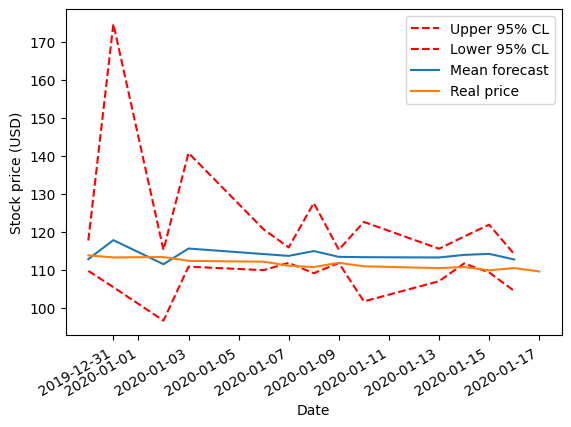

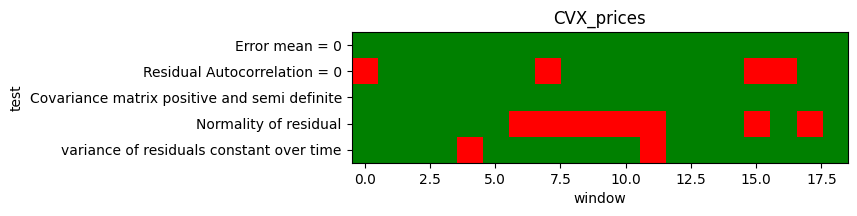

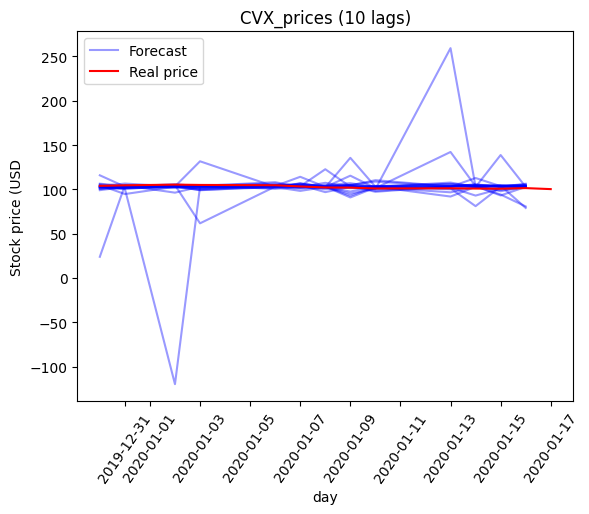

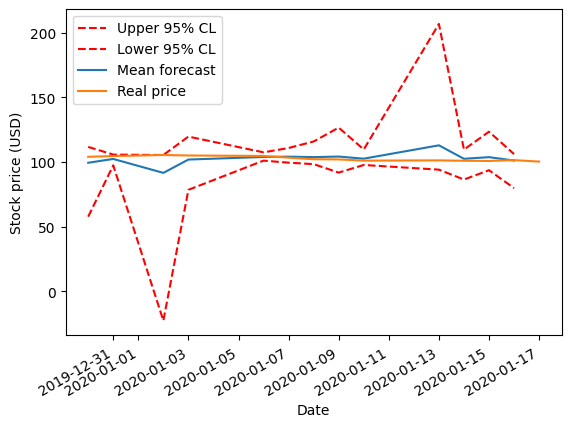

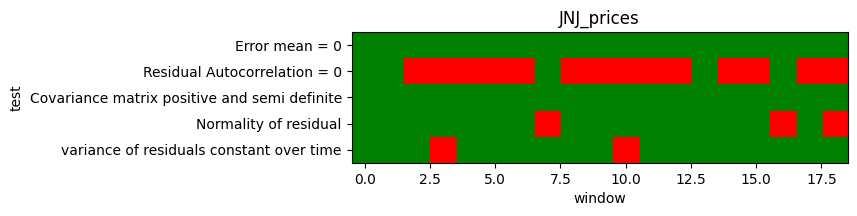

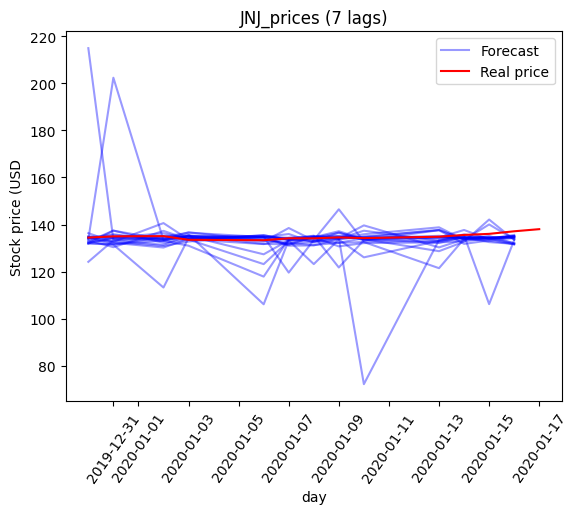

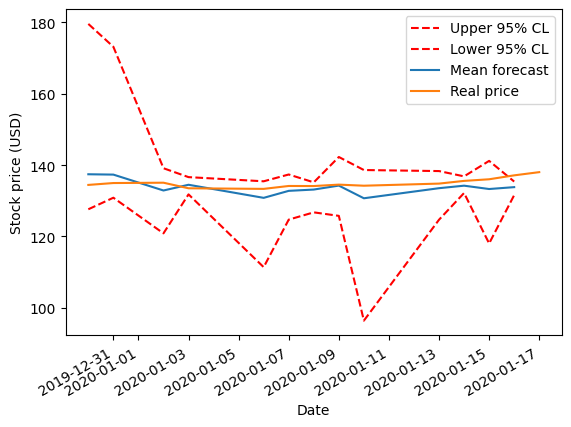

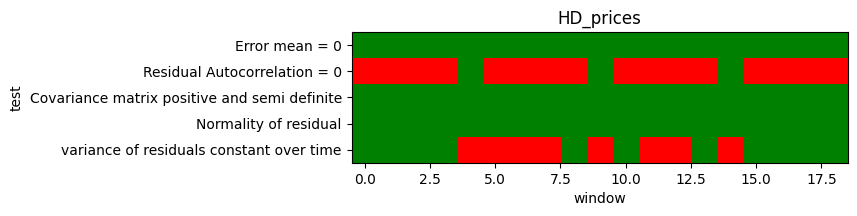

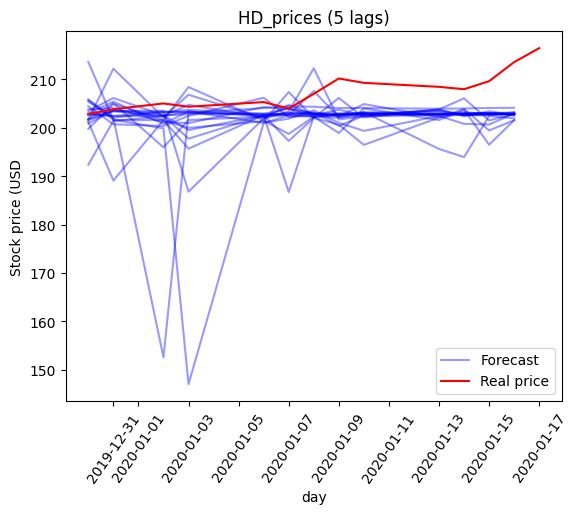

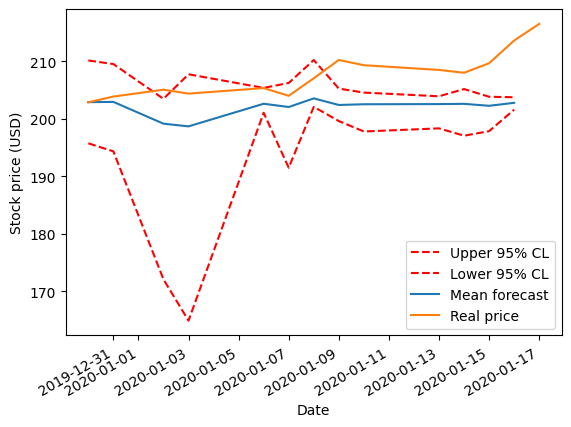

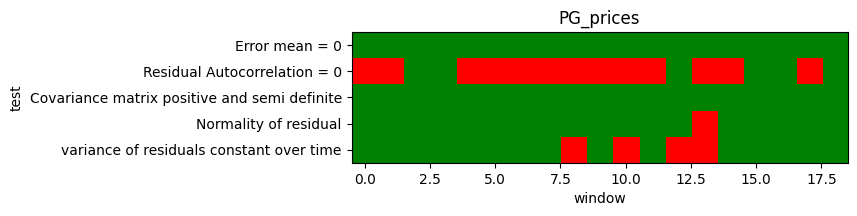

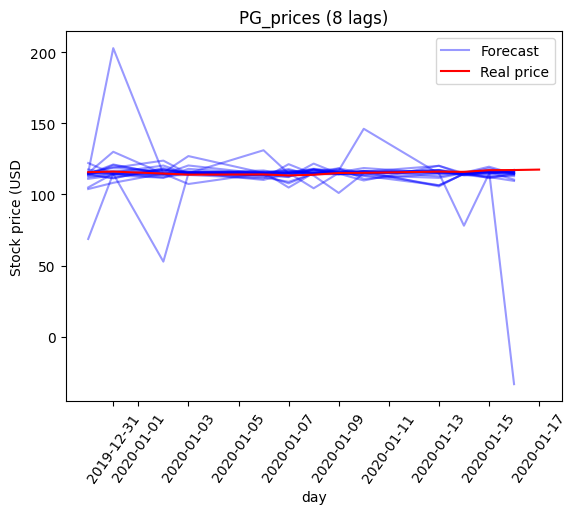

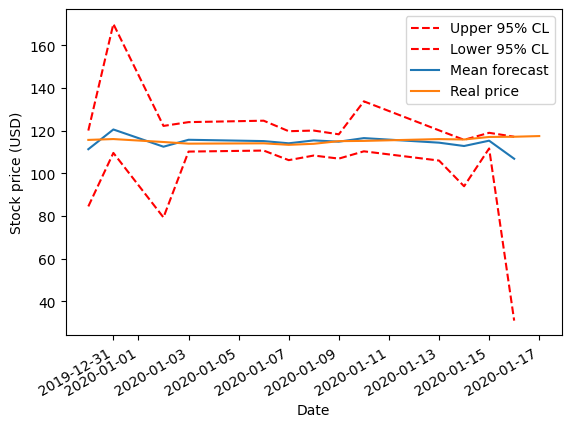

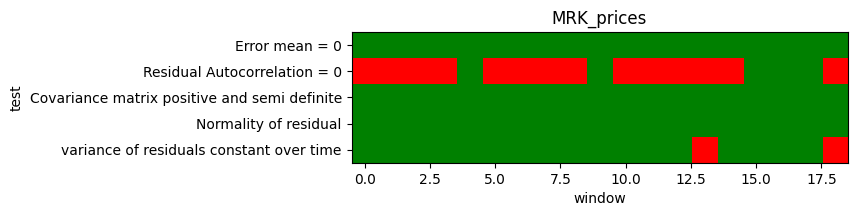

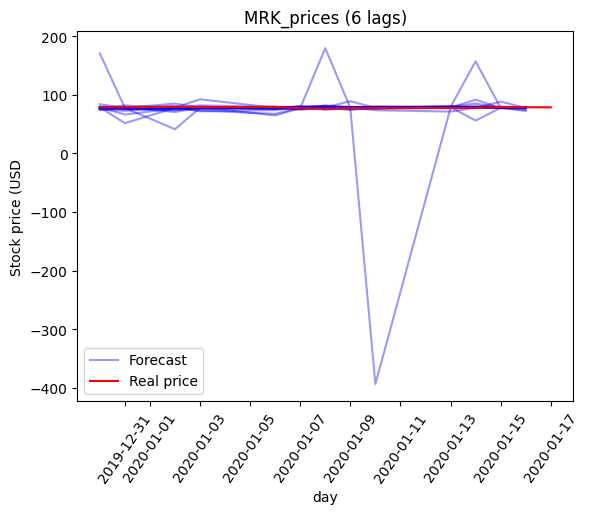

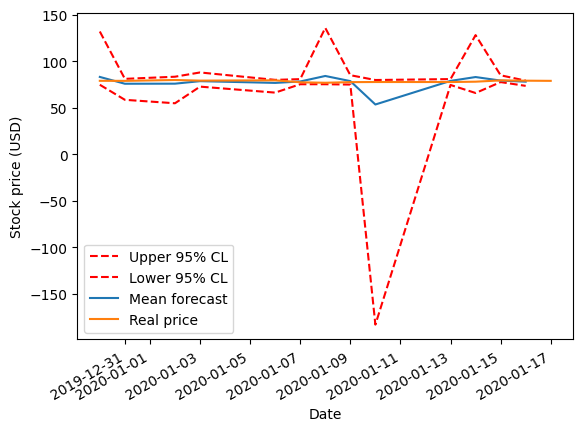

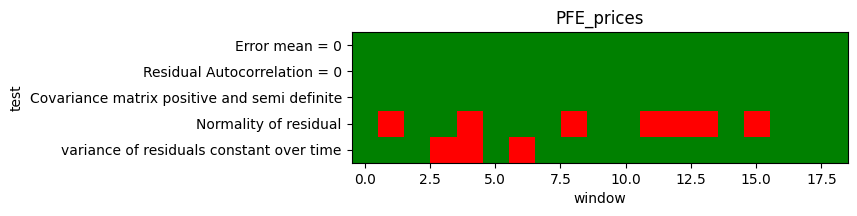

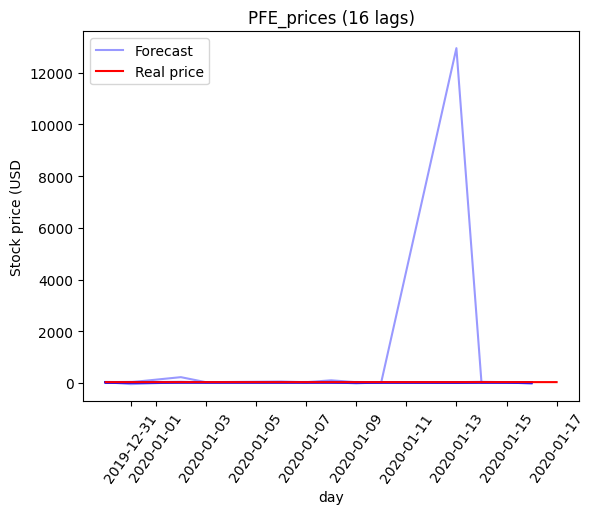

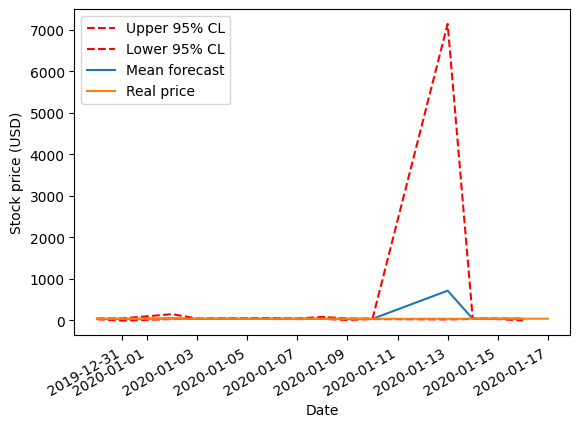

In [ ]:
all_forecasts = []
all_real_prices = []
for i, merged_df in enumerate(merged_dfs):

    # Make VAR models from sliding windows
    windows = sliding_windows(merged_df, window_size = 78)
    var_models_windows, merged_windows = VAR_model_windows(windows)

    # Fit the VAR models
    window_results = []
    for model in var_models_windows:
        result = model.fit(lags_stocks[i])
        window_results.append(result)

    matrix = Assumption_matrix(window_results)
    plot_assumptions(matrix)

    # Get the forecasted prices and plot the forecast for each window
    forecasted_prices, real_prices = forecast_windows(window_results, merged_windows)
    plot_forecasts(forecasted_prices, real_prices)

    all_forecasts.append(forecasted_prices)
    all_real_prices.append(real_prices)

    mean_forecast, df_percentiles = mean_forecasts(forecasted_prices)
    plot_mean_forecasts(mean_forecast, df_percentiles, real_prices)
    print("================================================================")


# Residual analysis

To say something about the quality of the prediction we need a quantative measure. Let's use the root-mean-squared-error (RMSE) of the prediction relative to the real prices for this.

In [ ]:
stock_names = [result.names[0] for result in results]
print(stock_names)

['AAPL_prices', 'MSFT_prices', 'BAC_prices', 'AMZN_prices', 'TSLA_prices', 'XOM_prices', 'JPM_prices', 'KO_prices', 'WMT_prices', 'CVX_prices', 'JNJ_prices', 'HD_prices', 'PG_prices', 'MRK_prices', 'PFE_prices']


In [ ]:
def RMSE(forecasted_prices, real_prices)-> tuple[list, list]:
    """Return the Root-mean-squared and the residuals over time of the forecasted prices
    relative to the real prices"""

    forecasted_prices = forecasted_prices.values
    real_prices = real_prices.values
    sqr_resid = [(real_prices[i]-forecasted_prices[i])**2 for i in range(len(forecasted_prices)-1)]
    RMSE = (np.mean(sqr_resid))**0.5

    return RMSE, np.sqrt(sqr_resid)

In [ ]:
RMSE_stocks = []
for stock_forecast, real_prices in zip(all_forecasts, all_real_prices):
    RMSE_windows = [RMSE(stock_forecast[i], real_prices["Close"])[0] for i in range(len(stock_forecast))]
    RMSE_stocks.append(RMSE_windows)

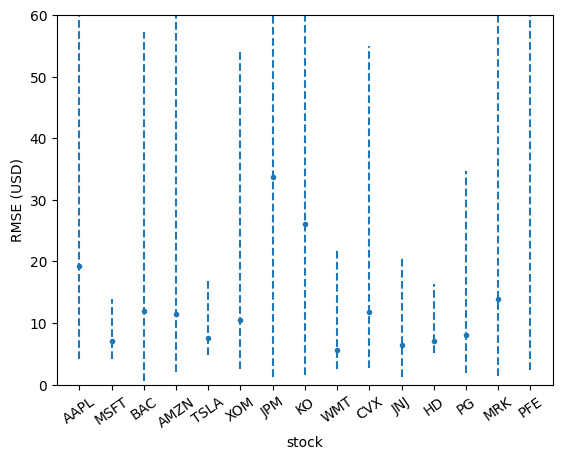

In [ ]:
means = [np.mean(RMSE_windows) for RMSE_windows in RMSE_stocks]
errors = [[np.percentile(RMSE_windows, 2.5), np.percentile(RMSE_windows, 97.5)] for RMSE_windows in RMSE_stocks]


index = [i for i in range(len(means))]

fig, ax = plt.subplots(1,1)
ax.plot(index, means, ".")
ax.set_xticks(range(15))
ax.set_xticklabels([stock_name[:-7] for stock_name in stock_names], rotation =35)
plt.xlabel("stock")
plt.ylabel("RMSE (USD)")
plt.ylim(0, 60)
for i, error in enumerate(errors):
    plt.vlines(i, ymin = error[0], ymax = error[1], linestyles="dashed")
plt.show()


We can also look at the average residuals over time for all the stocks to get a better sense of the quality of our model.

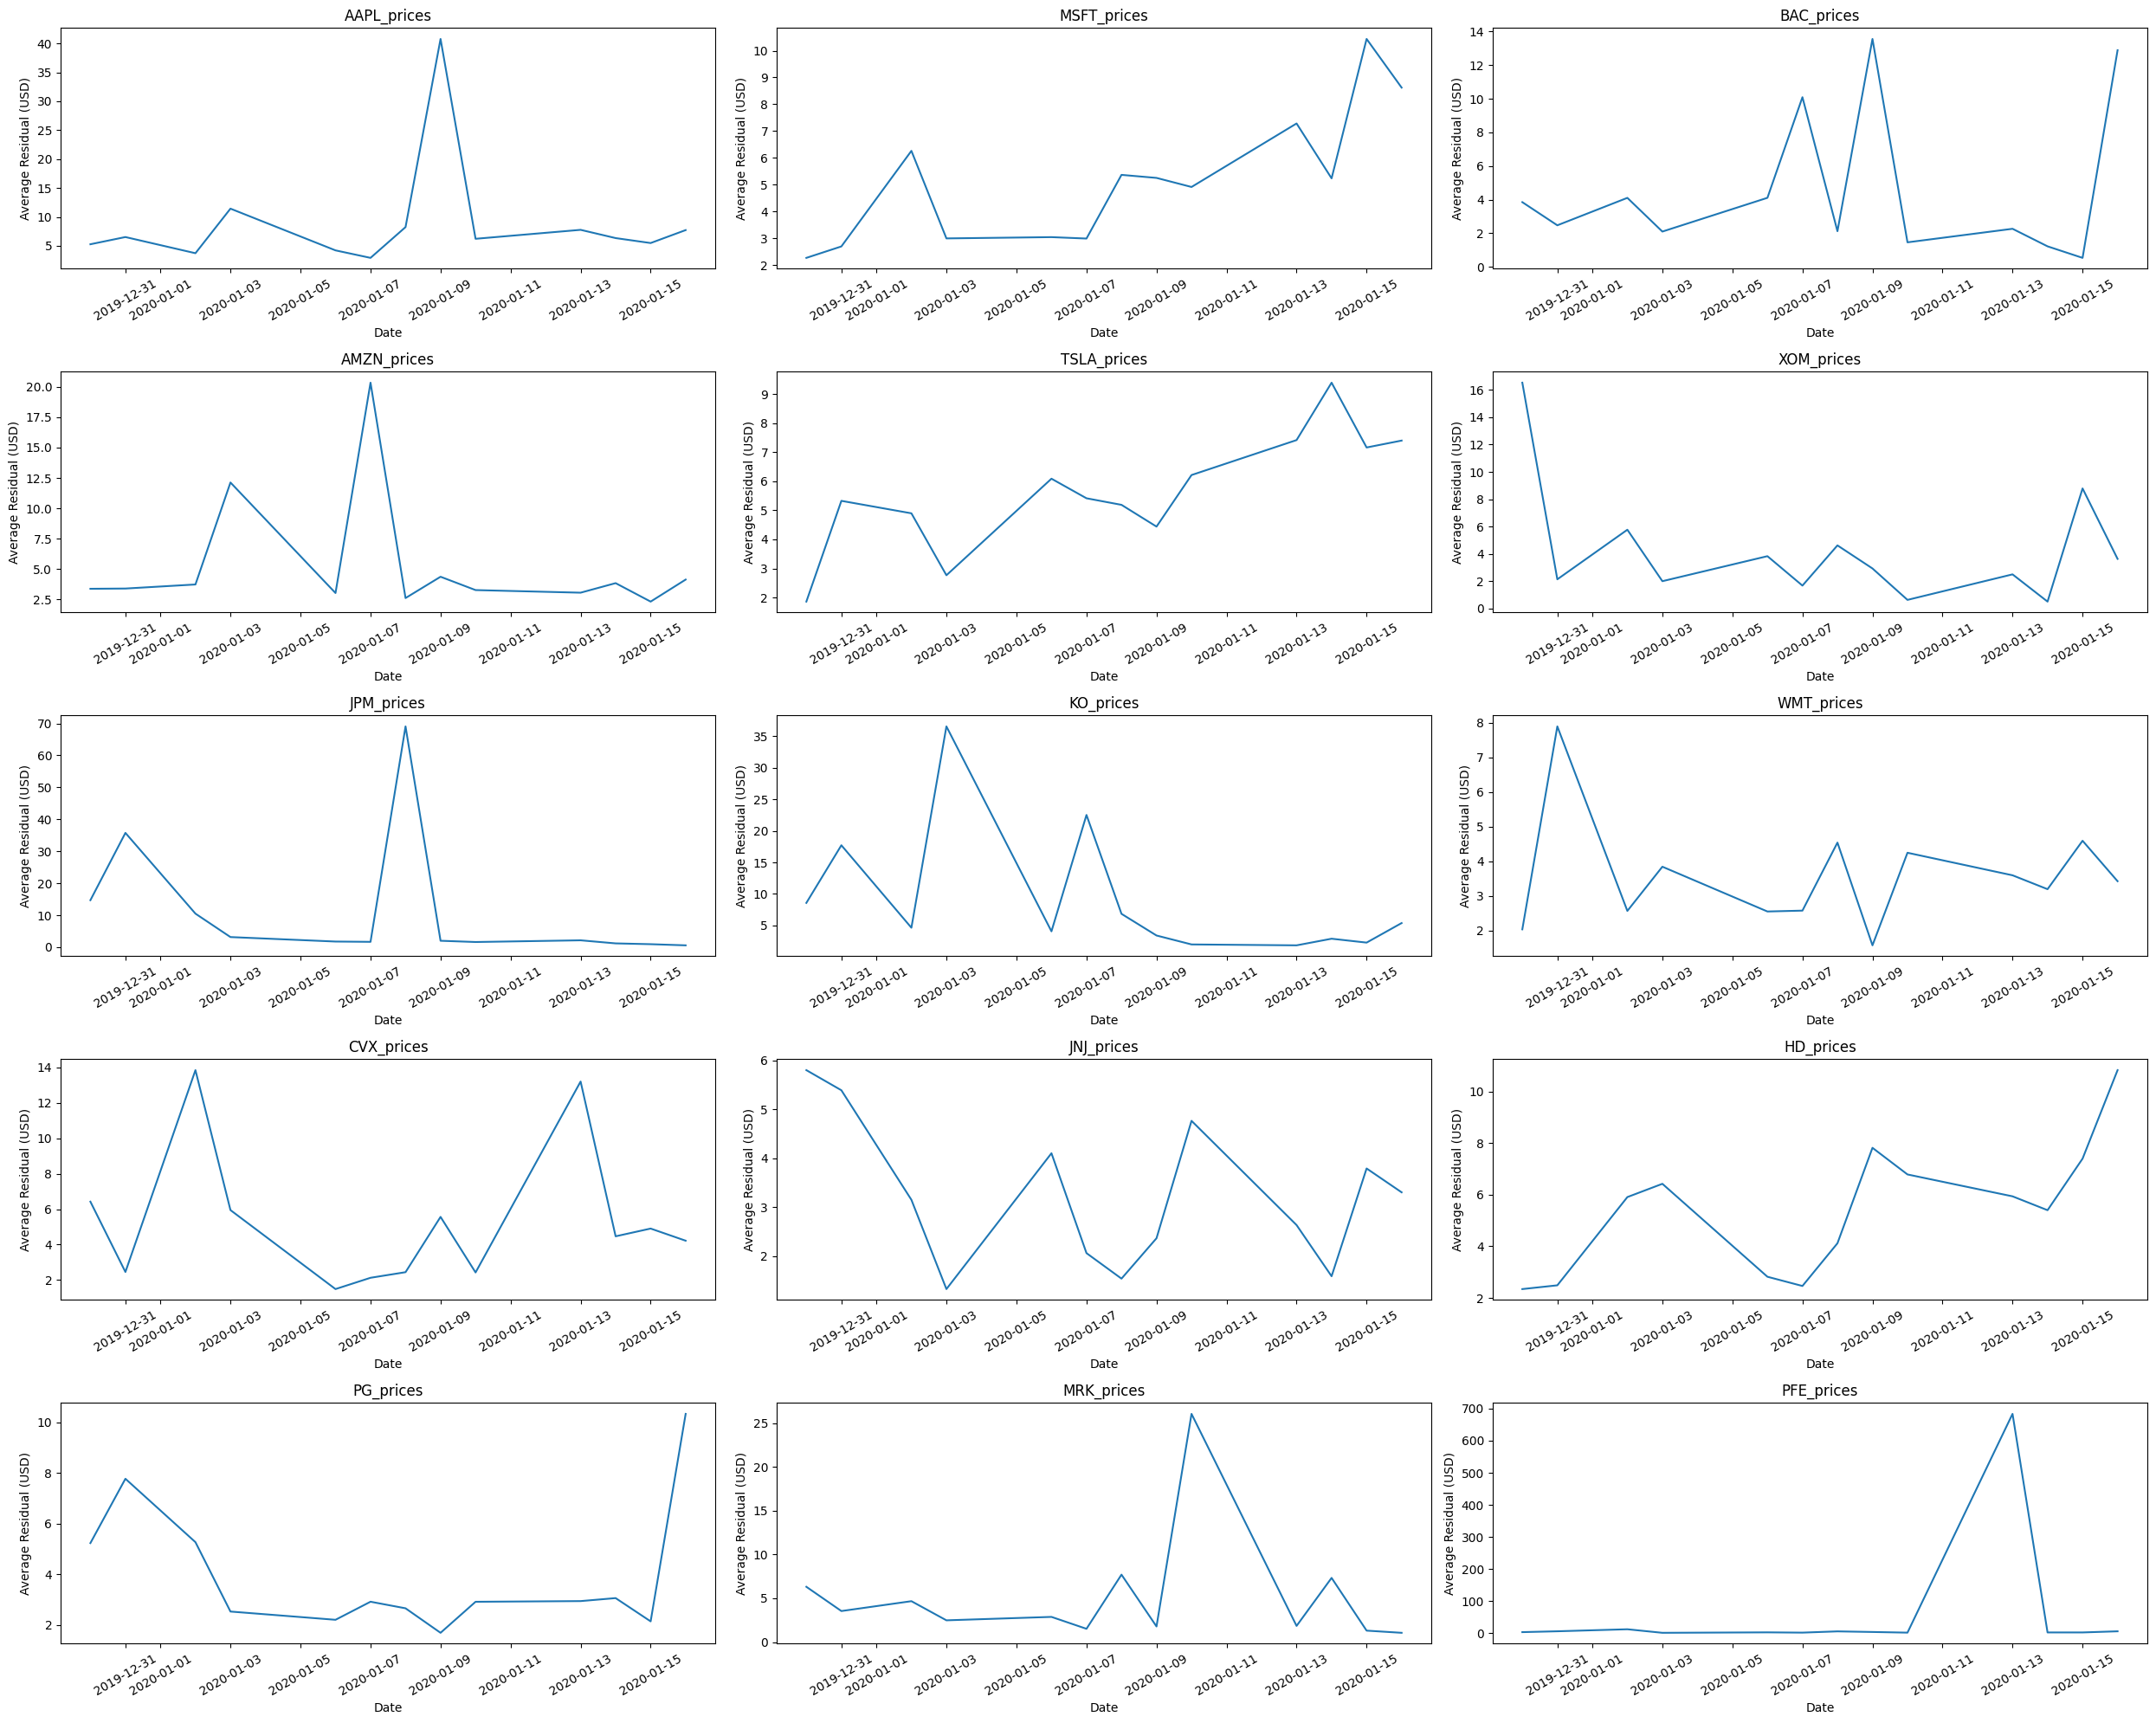

In [ ]:
resids_stocks = []
i = 1
fig = plt.figure(figsize=(25,20))
for stock_forecast, real_prices in zip(all_forecasts, all_real_prices):

    # Compute the residuals for each window and put it in a 2D array
    resids_windows = np.array([RMSE(stock_forecast[i], real_prices["Close"])[1] for i in range(len(stock_forecast))])

    # Compute average the residuals over all windows
    mean_resids_stock = np.average(resids_windows, axis=0)

    dates = stock_forecast[0].index[0 :-1] # Last date no data for the forecast.

    plt.subplot(5, 3, i)
    plt.plot(dates, mean_resids_stock)
    plt.xticks(rotation=30)
    plt.title(f"{stock_names[i-1]}")
    plt.xlabel("Date")
    plt.ylabel("Average Residual (USD)")
    i += 1

fig.tight_layout()
plt.show()

The residuals over time do not agree with what we expect from a timeseries prediction, namely that the residuals increase over time.

# Residuals original forecast (without windows)

It is usefull to do the same for the forecast without windows, so we can compare the quality of prediction of the two.

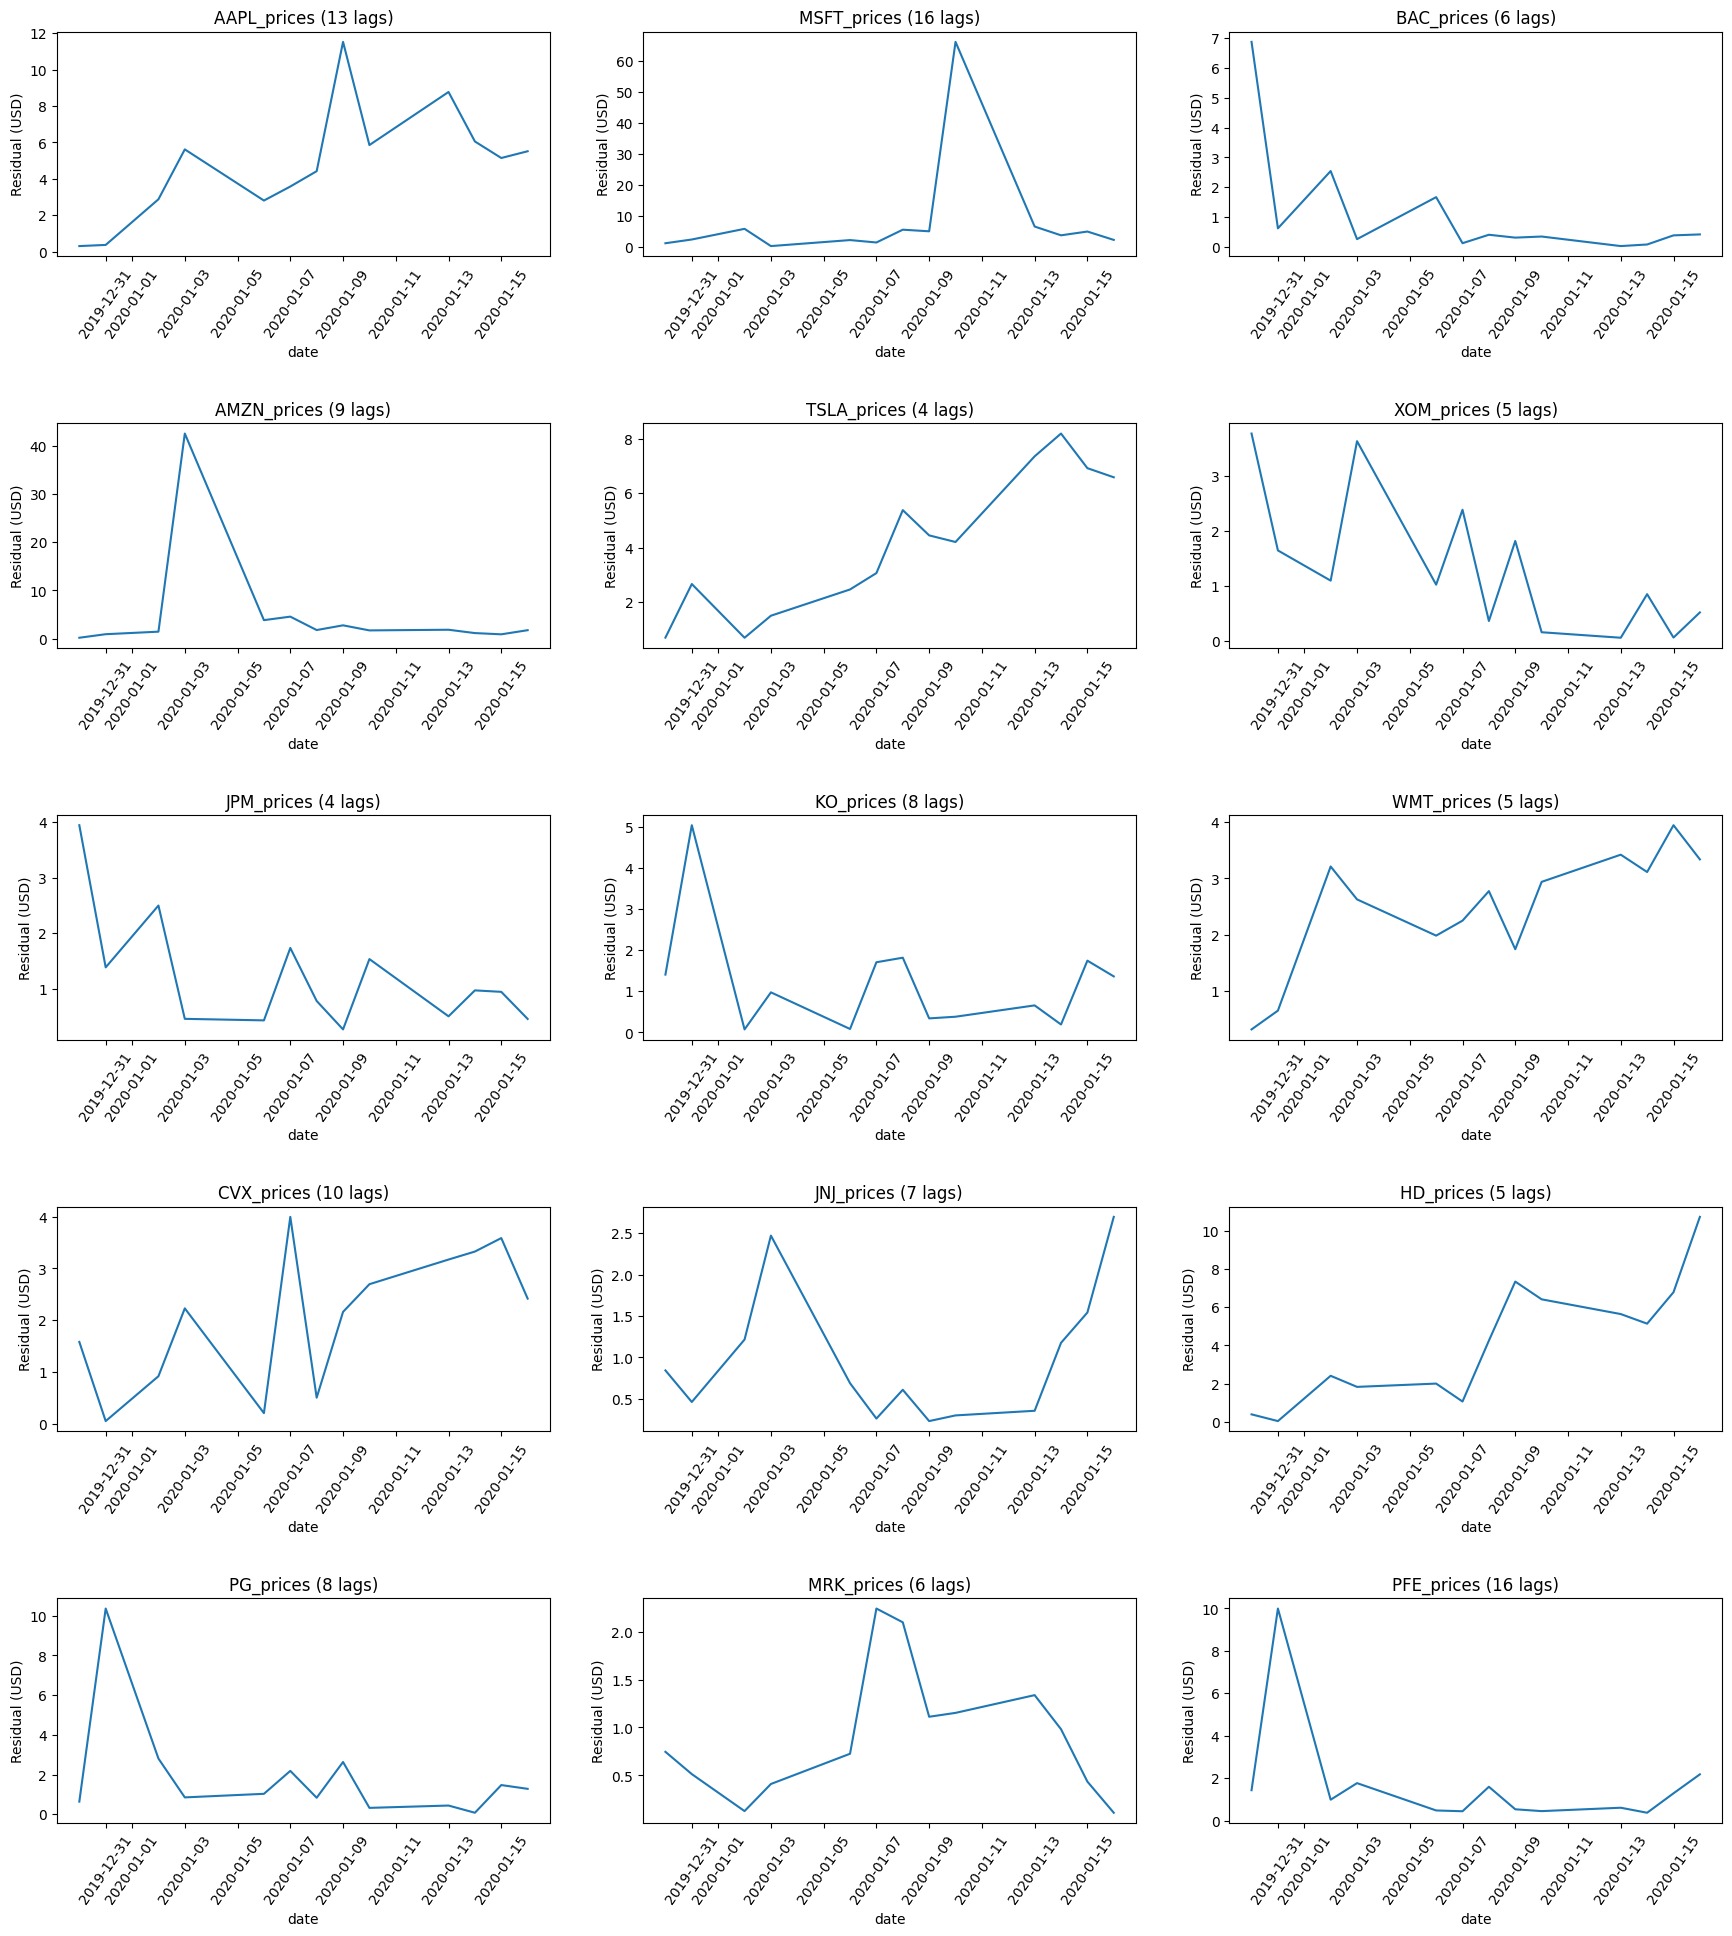

In [ ]:
original_forecasts = []
fig = plt.figure(figsize = (18, 20))
i = 0
for result, merged_df in zip(results, merged_dfs):
    i+=1
    forecasted, real_prices = forecast(result, merged_df)
    original_forecasts.append(forecasted)
    residuals = RMSE(forecasted["price"], real_prices["Close"])[1]
    plt.subplot(5, 3, i)
    plt.title(f"{result.names[0]} ({result.k_ar} lags)" )
    plt.xlabel('date')
    plt.ylabel('Residual (USD)')
    days = real_prices.index[:-1] # Last date no data for forecast
    plt.plot(days, residuals)
    plt.xticks(rotation=55)
fig.tight_layout(pad = 3)
plt.show()

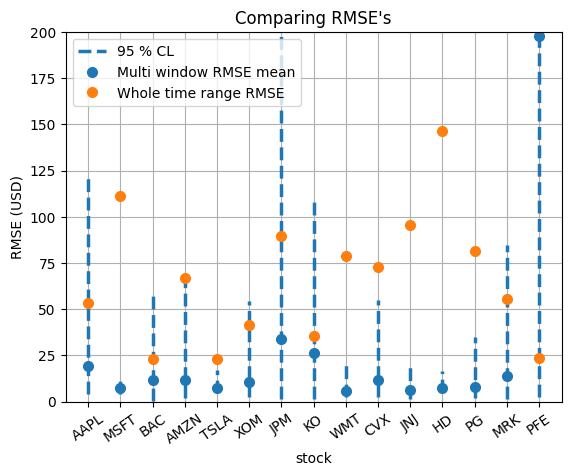

In [ ]:
means_orig = [RMSE(original_forecasts[i], all_real_prices[i])[0] for i in range(len(original_forecasts))]
stock_names = [stock_name[:-7] for stock_name in stock_names]

fig, ax = plt.subplots(1,1)
label = "_nolegend_"
for i, error in enumerate(errors):
    if i == len(errors)-1:
        label = "95 % CL"
    plt.vlines(i, ymin = error[0], ymax = error[1], linestyles="dashed", linewidth=2.5, label=label)
ax.plot(index, means, ".", markersize = 14, label = "Multi window RMSE mean")
ax.plot(index, means_orig, '.', markersize = 14, label = "Whole time range RMSE")
ax.grid()
ax.set_xticks(range(15))
ax.set_xticklabels(stock_names, rotation =35)
plt.xlabel("stock")
plt.ylabel("RMSE (USD)")
plt.title("Comparing RMSE's")
plt.ylim(0, 200)
plt.legend()
plt.show()

We can observe in the plot above, that the prediction gets significantly better when using a sliding window instead of the whole time range.

In [ ]:
df = pd.DataFrame(index= ["Mean_RMSE", "CL"],  columns = stock_names)
for i, stock in enumerate(stock_names):
    df[stock] = [means[i], errors[i]]
df

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
Mean_RMSE,19.319754,7.114943,11.898609,11.467378,7.56643,10.519938,33.615173,25.991118,5.682111,11.801804,6.403626,7.120249,8.054231,13.960855,197.970584
CL,"[4.073562828799888, 121.6218728114668]","[4.22171549283932, 13.860475586030558]","[0.5122732965652953, 57.270366855214036]","[2.037384046152742, 65.15305525665832]","[4.816382246160892, 16.97081652911841]","[2.5529427341891244, 54.13537416394303]","[1.1946325613416648, 277.068744245503]","[1.5411440696439673, 110.17331415750547]","[2.5707922114147492, 22.104934097046076]","[2.69234749816766, 54.8912830545478]","[1.223943960444071, 20.793687785987025]","[5.135301064383094, 16.275738081018734]","[1.7970823119456927, 34.72700899982675]","[1.3113213004489097, 84.79493693770937]","[2.3205585376739752, 1994.9087189067973]"


In [ ]:
df.to_csv("../data/RMSE_var.csv")